In [134]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
import json
import matplotlib.pyplot as plt

def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


def buy_fee(x,  f_min, f_max, w_buy):
    return min(f_max, f_min + w_buy * max(0, x))


def sell_fee(x,  f_min, f_max, w_sell):
    return min(f_max, f_min - w_sell * min(0, x))


def cost_function_buy(k, delta_ps, f_min, f_max, w_buy, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([buy_fee(x,  f_min, f_max, w_buy) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


def cost_function_sell(k, delta_ps, f_min, f_max, w_sell, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(-x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([sell_fee(x,  f_min, f_max, w_sell) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.rename(columns={'LVR_clean': 'price_diff', 'LVR': 'arb_pnl' })
data = data.sort_values('time')
current_liquidity_usd = 166.31 * 10**6

In [135]:
with open('gas_prices_final.json', 'r') as file:
    gas_price_eth = json.load(file)

data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['arb_pnl']/data['price_dex']

data['avg_block_gas'] = data['blockNumber'].astype(str).map(gas_price_eth)
data['avg_gas']    = data['gasUsed'] * data['avg_block_gas'].rolling(20).mean() * data['price_dex']
data['arb_fee']    = (np.abs(2*data['arb_pnl']) - data['avg_gas'])*100 / data['amountUSD']

data['LVR_zscore'] = zscore(data['arb_pnl'])

data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = (data['amount0'].apply(lambda x: (2*x + x**2)/current_liquidity_usd)*100/data['price_dex'])

data['time_diff']          = data['time'].diff().dt.total_seconds().fillna(0)

data['rol_1min_span']      = data['time_diff'].rolling(window=60, min_periods=1).sum() 
data['rol_1m_trade_count'] = data['time'].rolling(window=60, min_periods=1).count()
data['lambda_1min']        = data['rol_1m_trade_count'] / data['rol_1min_span']
data['lambda_1min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)

data['rol_5min_span']      = data['time_diff'].rolling(window=60*5, min_periods=1).sum() 
data['rol_5m_trade_count'] = data['time'].rolling(window=60*5, min_periods=1).count()
data['lambda_5min']        = data['rol_5m_trade_count'] / data['rol_5min_span']
data['lambda_5min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = (-np.sign(data['amount1']) * data['arb_fee']/100).clip(-0.1, 0.1)

data = data.dropna()

features = ['LVR_nbtoken',
            'price_diff', 
            'arb_pnl', 
            'std',
            'price_impact',
            #'mean_rol_amount', 'avg_gas',  'rol_amountUSD',
            'lambda_1min',# 'rol_1min_span', 'rol_1m_trade_count', 
            'lambda_5min',# 'rol_5min_span', 'rol_5m_trade_count', 
            'amountUSD',
            ]
target = 'target_fee' # 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

# max and min fee in %
f_min = 0.03
f_max = 0.1

params = {}
for f in features:
    params[f] = {'lower_quantile': 0.1, 'upper_quantile': 0.9}
    
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,mean_rol_amount,rol_amountUSD,price_impact,rol_1min_span,rol_1m_trade_count,lambda_1min,rol_5min_span,rol_5m_trade_count,lambda_5min,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,31679.388299,3.274054e+06,0.010468,1032.0,60.0,0.058140,1404.0,100.0,0.071225,-0.001895
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,31196.151489,3.256138e+06,0.000007,1032.0,60.0,0.058140,1404.0,101.0,0.071937,0.100000
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,31203.846347,3.255538e+06,0.000003,1044.0,60.0,0.057471,1428.0,102.0,0.071429,0.099442
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,20749.062023,3.232065e+06,0.000591,1056.0,60.0,0.056818,1476.0,103.0,0.069783,-0.006757
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,20425.349686,3.231848e+06,0.000079,1080.0,60.0,0.055556,1500.0,104.0,0.069333,0.019911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,18890.788832,1.082558e+06,0.001369,1116.0,60.0,0.053763,4092.0,300.0,0.073314,0.007469
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,19990.184415,1.018821e+06,0.059305,1128.0,60.0,0.053191,4116.0,300.0,0.072886,-0.001129
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,20063.044481,1.015755e+06,0.000264,1140.0,60.0,0.052632,4104.0,300.0,0.073099,-0.014507
187224,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,...,31966.914977,1.179945e+06,7.110914,1128.0,60.0,0.053191,4080.0,300.0,0.073529,0.000826


In [136]:
# Get the factor weightings
X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

feature_importances = model.feature_importances_ / model.feature_importances_.sum()
features_importance_normalized = {feature: importance for feature, importance in zip(features, feature_importances)}
features_importance_normalized

{'LVR_nbtoken': 0.11244808652206498,
 'price_diff': 0.24521492066117276,
 'arb_pnl': 0.14341152963013512,
 'std': 0.06428995301924602,
 'price_impact': 0.06565513103599101,
 'lambda_1min': 0.04294491184766457,
 'lambda_5min': 0.05153227617757818,
 'amountUSD': 0.27450319110614746}

In [137]:
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:   
    low_q  = params[f]['lower_quantile']
    high_q = params[f]['upper_quantile']

    scale_min = data_filtered[f].quantile(high_q)
    scale_max = data_filtered[f].quantile(low_q)
    delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)}) 

    if len(sell_subset[sell_subset[f]<0])>0:
        sell_max_fee_q = sell_subset[sell_subset[f]<0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]<0][f].quantile(high_q)
    else :
        sell_max_fee_q = sell_subset[sell_subset[f]>0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]>0][f].quantile(high_q)
        
    if len(buy_subset[buy_subset[f]>0])>0:
        buy_max_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(high_q)
    else:
        buy_max_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(high_q)

    w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
    w_sell = np.abs((f_max-f_min)/sell_max_fee_q)
    
    buy_subset[f'{f}_fee'] = buy_subset[f].apply(lambda x: buy_fee(x, f_min, f_max, w_buy))
    if data_filtered[f].min() >= 0:
        w_sell = w_sell.clip(0, 1)
        sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: sell_fee(-x, f_min, f_max, w_sell))
    else:
        sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: sell_fee(x, f_min, f_max, w_sell))
        
combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)/100

combined_data['selling_fee'] = 0 
combined_data['buying_fee']  = 0 

combined_data.loc[combined_data['amount0'] < 0, 'selling_fee'] = combined_data['combined_fee']
combined_data.loc[combined_data['amount1'] < 0, 'buying_fee'] = combined_data['combined_fee']

combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']



In [138]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'price_diff'          : 'last',
    'arb_pnl'             : 'sum',
    'price_impact'        : 'sum', # or mean maybe
    'lambda_5min'         : 'last',
    'lambda_1min'         : 'last',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'avg_gas'             : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'last',
    'selling_fee'         : 'last',
    'buying_fee'          : 'last',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()
metrics['std'] = metrics['close'].rolling(window=60).std()

metrics['future_close'] = metrics['close'].shift(-60)
#metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee'].abs() * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = (pool_fee_rate*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = ((1-pool_fee_rate)*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_5m'] = (metrics['cpnl_5m_negative'].abs() / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = (metrics['combined_fee'].abs()*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = ((1-metrics['combined_fee'].abs())*metrics['arb_pnl']).rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_5m'] = (metrics['dpnl_5m_negative'].abs() / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,price_diff,arb_pnl,price_impact,...,dpnl,cfee_cumul,dfee_cumul,avg_7m_cfee,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_5m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_5m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 20:27:00,2342.126859,2342.126859,2341.892670,2341.892670,-7958.181626,3.400618,11250.708999,1.157330,4.001189,0.012206,...,7.297506,7309.023115,9414.905376,5.869687,0.003913,-4.760108,-1.000239,0.004736,-4.759108,-1.000289
2024-01-22 22:16:00,2331.611491,2331.611491,2331.611491,2331.611491,-514.694228,0.221152,1814.103578,0.538509,0.119092,0.000459,...,0.870471,206932.451693,274183.048060,10.967678,0.000617,-29.530049,-1.000009,0.000624,-29.515513,-1.000009
2024-01-22 22:17:00,2331.611491,2331.611491,2331.611491,2331.611491,-15498.290812,6.652051,20912.079940,-0.601491,-1.860061,0.025390,...,14.428680,206942.907733,274197.476740,11.498030,0.000617,-2.686670,-1.000039,0.000624,-2.686139,-1.000040
2024-01-22 22:18:00,2331.611491,2331.611491,2331.611491,2331.611491,-7433.310918,3.189932,7428.654359,-0.511491,-0.806153,0.004222,...,4.811220,206946.622060,274202.521097,6.467687,0.000564,-3.492420,-1.000061,0.000581,-3.491744,-1.000062
2024-01-22 22:19:00,2331.611491,2331.611491,2331.378353,2331.378353,-144426.277854,61.985607,159529.405973,-0.528353,-32.965595,3.016754,...,103.730871,207026.386763,274309.280640,14.221667,0.000564,-35.613993,-1.000063,0.000581,-35.607917,-1.000064
2024-01-22 22:20:00,2330.446035,2330.446035,2328.349682,2328.349682,13224.826750,-5.674650,14844.793331,-0.269682,3.126234,0.019892,...,9.522285,207033.809160,274318.802925,15.261563,0.001623,-35.613993,-1.000069,0.002062,-35.607917,-1.000072
2024-01-22 22:21:00,2328.349682,2328.582517,2328.349682,2328.349682,-2913.448606,1.252761,6976.758385,-1.089682,-1.236583,0.004036,...,4.267040,207037.297539,274324.001072,15.546895,0.001563,-36.849957,-1.000075,0.002005,-36.843578,-1.000080
2024-01-22 22:22:00,2328.116870,2328.116870,2327.418575,2327.418575,-57865.695084,24.873127,63007.133865,-0.968575,-28.142829,0.598329,...,55.272254,207068.801106,274379.273326,19.608066,0.001563,-63.119584,-1.000077,0.002005,-63.102942,-1.000083
2024-01-23 21:20:00,2191.010308,2191.010308,2188.382804,2188.382804,-2694.714287,1.233505,7626.595921,0.307196,0.690735,0.004602,...,6.365138,219580.845104,290976.807415,23.016325,0.000345,-96.729351,-1.000149,0.000418,-96.693366,-1.000189


In [144]:
add_per = (metrics['dpnl'] - metrics['cpnl']).sum()/current_liquidity_usd
print('Additional profits of the dynamic fee over the constant fee model: ', round(add_per*100,2), '%')
print('')
price_impact_improvments = 1 - 1/(1+add_per)
print('Price impact of the dynamic fee model decreased by: ', round(price_impact_improvments*100,2), '%')
print('')
print(f"The average constant fees is: {0.05}")
average_fee_positive = combined_data[combined_data['amount1'] < 0]['combined_fee'].abs().mean()*100
average_fee_negative = combined_data[combined_data['amount0'] < 0]['combined_fee'].abs().mean()*100

print(f"The average dynamic selling fees is: {round(average_fee_positive, 2)}")
print(f"The average dynamic buying  fees is: {round(average_fee_negative, 2)}")
print('')
print(f"The total constant fees are: {round(metrics['cfee'].abs().sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].abs().sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")
# print('')
# print(f"The % of toxic pnl flow in constant fee: {round(((metrics['c%_toxic_flow_ma_5m'].abs()-1)*100).clip(-1,1).mean()*100,2)}")
# print(f"The % of toxic pnl flow in dynamic  fee: {round(((metrics['d%_toxic_flow_ma_5m'].abs()-1)*100).clip(-1,1).mean()*100,2)}")
print('')
print('The 1 min markout pnl is: ', round(metrics['markout'].sum(), 2))
print('The impermanent loss is : ', round(metrics['impermanent_loss'].sum()*100, 2))
print('Average tcost_usd     : ', round(metrics['tcost_usd'].mean(), 2))
print('')
weighted_fee = (combined_data['amountUSD'] * combined_data['combined_fee'].abs())/combined_data['amountUSD'].sum()
print('Average weighted_fee  : ', round(weighted_fee.mean()*100, 5))
print('Average selling_fee   : ', round(metrics['selling_fee'].abs().mean()*100, 2))
print('Average buying_fee    : ', round(metrics['buying_fee'].abs().mean()*100, 2))

combined_data.loc[combined_data['amount0'] < 0, 'selling_fee'] = combined_data['combined_fee']
combined_data.loc[combined_data['amount1'] < 0, 'buying_fee'] = combined_data['combined_fee']


weighted_buying_fee = ((combined_data[combined_data['amount1'] < 0]['buying_fee'] * combined_data[combined_data['amount1'] < 0]['amountUSD'])*100 / combined_data[combined_data['amount1'] < 0]['amountUSD'].sum()).sum()
weighted_selling_fee = ((combined_data[combined_data['amount1'] > 0]['selling_fee'] * combined_data[combined_data['amount1'] > 0]['amountUSD'])*100 / combined_data[combined_data['amount1'] > 0]['amountUSD'].sum()).sum()

print('Weighted average buying_fee: ', round(weighted_buying_fee, 2))
print('Weighted average selling_fee: ', round(weighted_selling_fee, 2))

# only 9% of the fees that we quote are in the range of the fee the arbitrager will be willing to pay
accuracy = (metrics['avg_gas'] + metrics['dfee'].abs() < metrics['tcost_usd']).mean()

print(f'{accuracy*100:.2f}% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay')
print('Average accuracy of the fee: ', round(accuracy*100, 2))

# can we know whats gonna be the price impact after this dynamic fee:
# we need to now what will be the liquidity in such pools at the permanent regime 
# this will depend on the profitability (returns of LP) of LP. 
# In average the liquidty is provided in a pool such that the returns are the same as a constant pool 
# we can then match the liquidity corresponding to this profitability and find the price impact at a given liquidity level for a given amount to swap

Additional profits of the dynamic fee over the constant fee model:  0.05 %

Price impact of the dynamic fee model decreased by:  0.05 %

The average constant fees is: 0.05
The average dynamic selling fees is: 0.07
The average dynamic buying  fees is: 0.05

The total constant fees are: 314445.21
The total dynamic  fees are: 415635.66

The total pnl with c are: 275670.28
The total pnl with d are: 363466.09

The 1 min markout pnl is:  309090473.37
The impermanent loss is :  -0.03
Average tcost_usd     :  38.77

Average weighted_fee  :  0.0
Average selling_fee   :  0.04
Average buying_fee    :  0.02
Weighted average buying_fee:  0.06
Weighted average selling_fee:  -0.08
4.20% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay
Average accuracy of the fee:  4.2


3 3


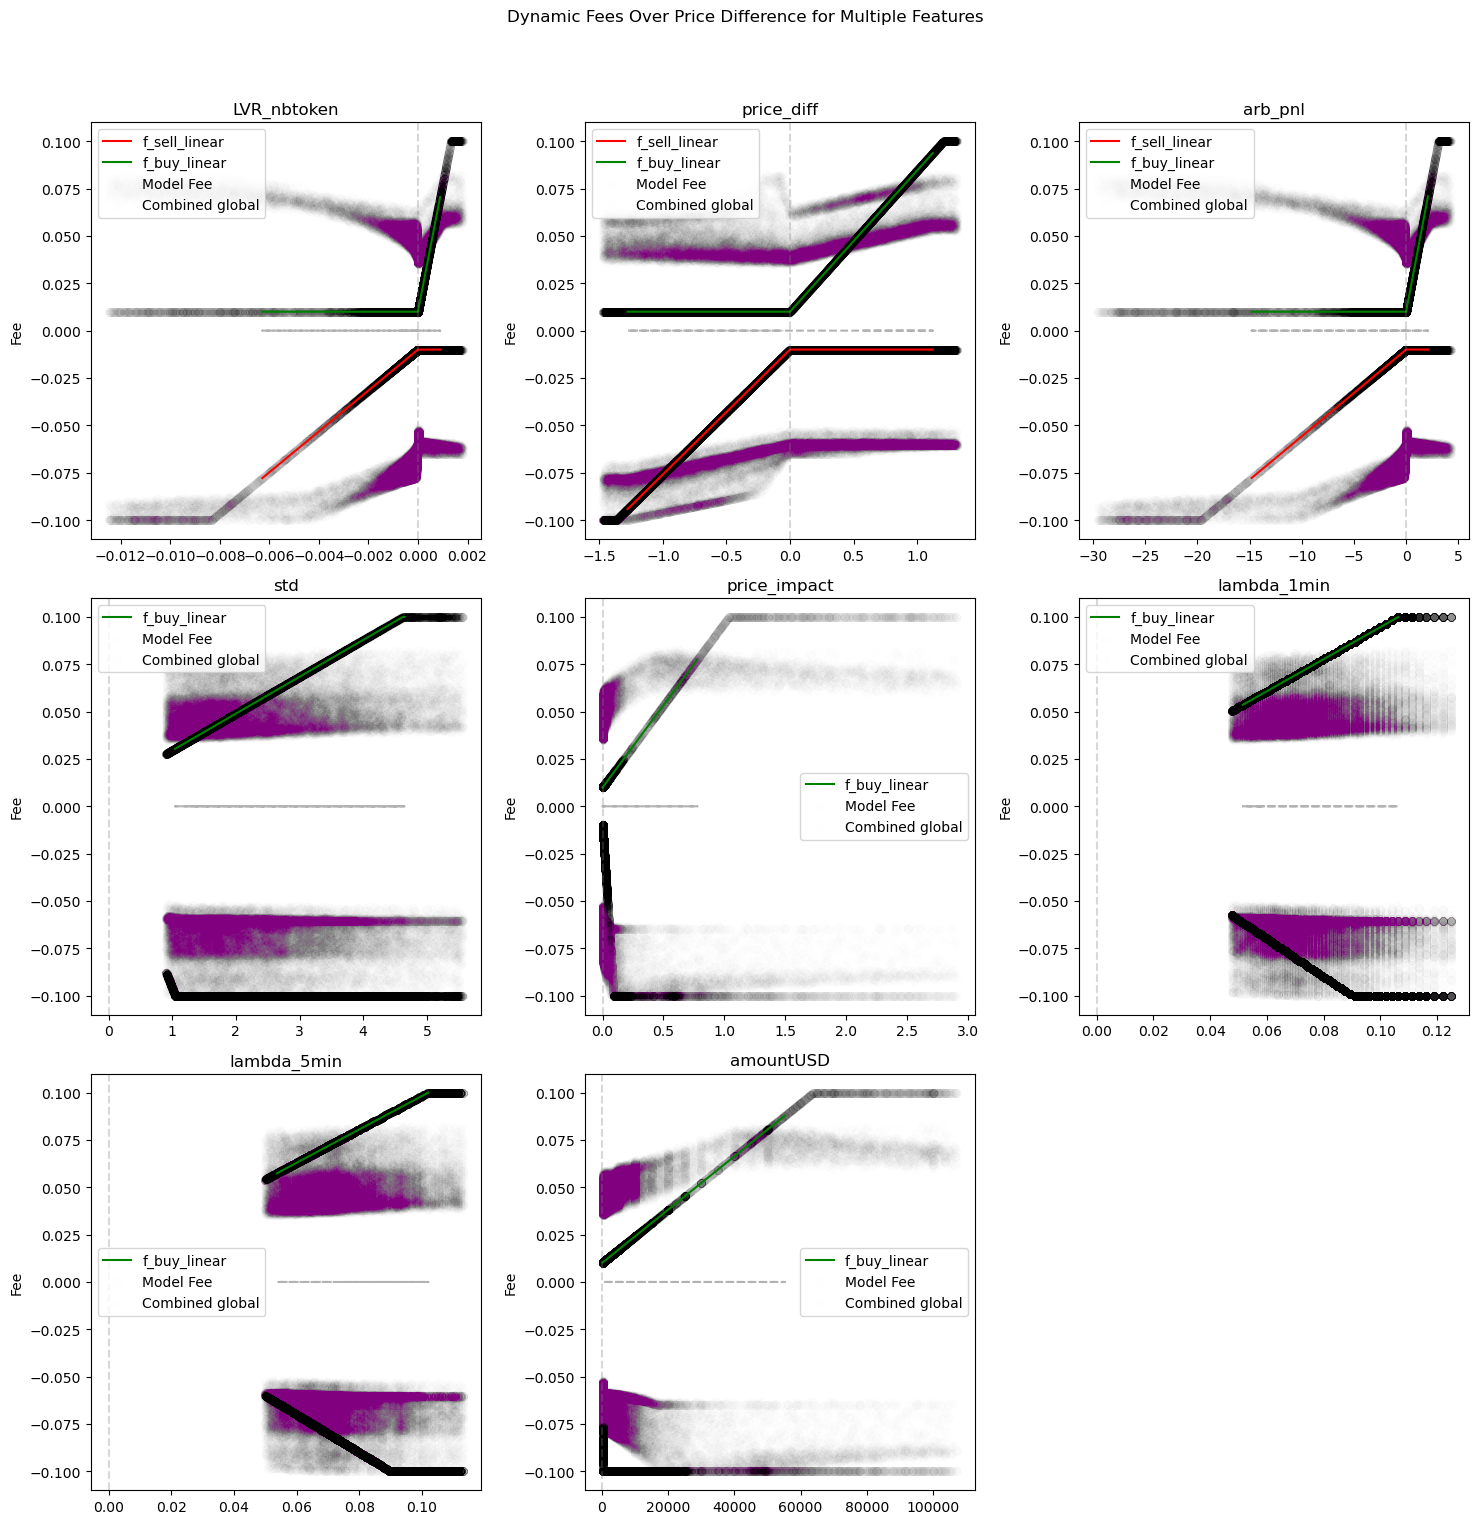

In [140]:
num_features = len(features)
cols = 3
rows = num_features // cols + (1 if num_features % cols > 0 else 0)
print(rows, cols)
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5 + 1))
fig.suptitle('Dynamic Fees Over Price Difference for Multiple Features')

f_min  = 0.01
f_max  = 0.1
low_q  = 0.05
high_q = 0.95

for i, feat in enumerate(features):
    row, col = divmod(i, cols)
    
    # Adjust how to access the subplot axes based on the dimensionality of 'axs'
    if num_features > 1:
        if axs.ndim > 1:  # If 'axs' is two-dimensional
            ax = axs[row, col]
        else:  # If 'axs' is one-dimensional
            ax = axs[i]
    else:
        ax = axs 

    scale_min = data_filtered[feat].quantile(high_q)
    scale_max = data_filtered[feat].quantile(low_q)
    delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)})

    # Segment the data based on 'amount1'
    buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
    sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

    if len(sell_subset[sell_subset[feat]<0])>0:
        sell_max_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(high_q)
    else :
        sell_max_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(high_q)
        
    if len(buy_subset[buy_subset[feat]>0])>0:
        buy_max_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(high_q)
    else:
        buy_max_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(high_q)
    
    w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
    w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

    # Apply the fees
    buy_subset['model_fee'] = buy_subset[feat].apply(lambda x: buy_fee(x, f_min, f_max, w_buy))
    if data_filtered[feat].min() >= 0:
        # Adjust sell_subset model_fee calculation for features that are always positive
        w_sell = w_sell.clip(0, 1)
        sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: sell_fee(-x, f_min, f_max, w_sell))
        #ax.plot(delta_p['delta_p'], delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * max(0, x))), label='f_sell_linear', color='red')
    else:
        sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: sell_fee(x, f_min, f_max, w_sell))
        ax.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
        
    fus_data = pd.concat([buy_subset, sell_subset])

    # plot the fees and the model fee
    ax.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w_buy * max(0, x))),  label='f_buy_linear', color='green')
    #ax.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
    
    filtered_plot = (fus_data[feat] >= fus_data[feat].quantile(low_q)) & (fus_data[feat] <= fus_data[feat].quantile(high_q))
    ax.scatter(fus_data[feat], fus_data['model_fee'], alpha=0.005, color='black', label='Model Fee')
    # ax.scatter(fus_data[filtered_plot][feat], fus_data[filtered_plot]['model_fee'], alpha=0.005, color='black', label='Model Fee')
    
    ax.scatter(combined_data[feat], combined_data['combined_fee']* 100, alpha=0.005, color='purple', label='Combined global')
    
    ax.plot(fus_data[filtered_plot][feat], [0]*len(fus_data[filtered_plot]), linestyle='--', alpha=0.3, color='black')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3) 

    ax.set_ylabel('Fee')
    ax.legend(loc='best')
    ax.set_title(feat)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for j in range(i + 1, rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_73590/3099796941.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=arb_pnl_norm, cmap=coolwarm), label='Average Arb PnL in %')


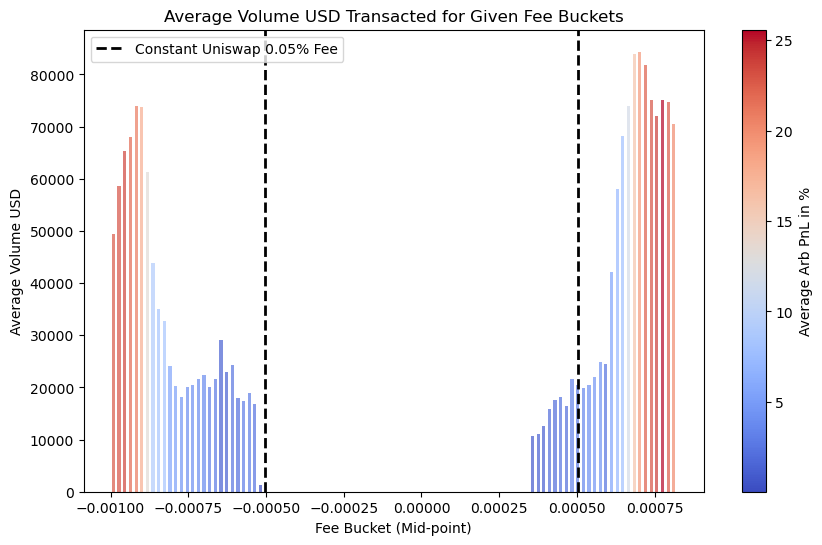

In [141]:
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

# Adjusting bins to a higher value for finer granularity
metrics['fee_bucket'] = pd.cut(metrics['combined_fee'], bins=100)  # Adjusted number of bins from 10 to 20

features.remove('amountUSD')  # Removes 'amountUSD' from the list
features.append('volumeUSD')

# Calculate the average 'volumeUSD' for each bucket
agg_metrics = metrics.groupby('fee_bucket')[['volumeUSD','arb_pnl']].mean().reset_index()

# Convert intervals to mid-points for plotting
agg_metrics['fee_bucket_mid'] = agg_metrics['fee_bucket'].apply(lambda x: x.mid).astype(float)

arb_pnl_norm = Normalize(vmin=agg_metrics['arb_pnl'].abs().min(), vmax=agg_metrics['arb_pnl'].abs().max())
norm_arb_pnl = arb_pnl_norm(agg_metrics['arb_pnl'].abs())

colors = coolwarm(norm_arb_pnl)

plt.figure(figsize=(10, 6))

plt.bar(agg_metrics['fee_bucket_mid'], agg_metrics['volumeUSD'].astype('float'), alpha=0.7, color=colors, width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)

plt.title('Average Volume USD Transacted for Given Fee Buckets')
plt.xlabel('Fee Bucket (Mid-point)')
plt.ylabel('Average Volume USD')
plt.colorbar(plt.cm.ScalarMappable(norm=arb_pnl_norm, cmap=coolwarm), label='Average Arb PnL in %')

closest_mid_point = agg_metrics['fee_bucket_mid'].sub(0.0005).abs().idxmin()
x_value_for_line = agg_metrics.loc[closest_mid_point, 'fee_bucket_mid']
plt.axvline(x=x_value_for_line, color='black', linestyle='--', linewidth=2, label='Constant Uniswap 0.05% Fee')
plt.axvline(x=-x_value_for_line, color='black', linestyle='--', linewidth=2)
plt.legend()

            
plt.show()

In [142]:
features.remove('LVR_nbtoken') 

['LVR_nbtoken',
 'price_diff',
 'arb_pnl',
 'std',
 'price_impact',
 'lambda_1min',
 'lambda_5min',
 'volumeUSD']

KeyError: "Columns not found: 'LVR_nbtoken'"

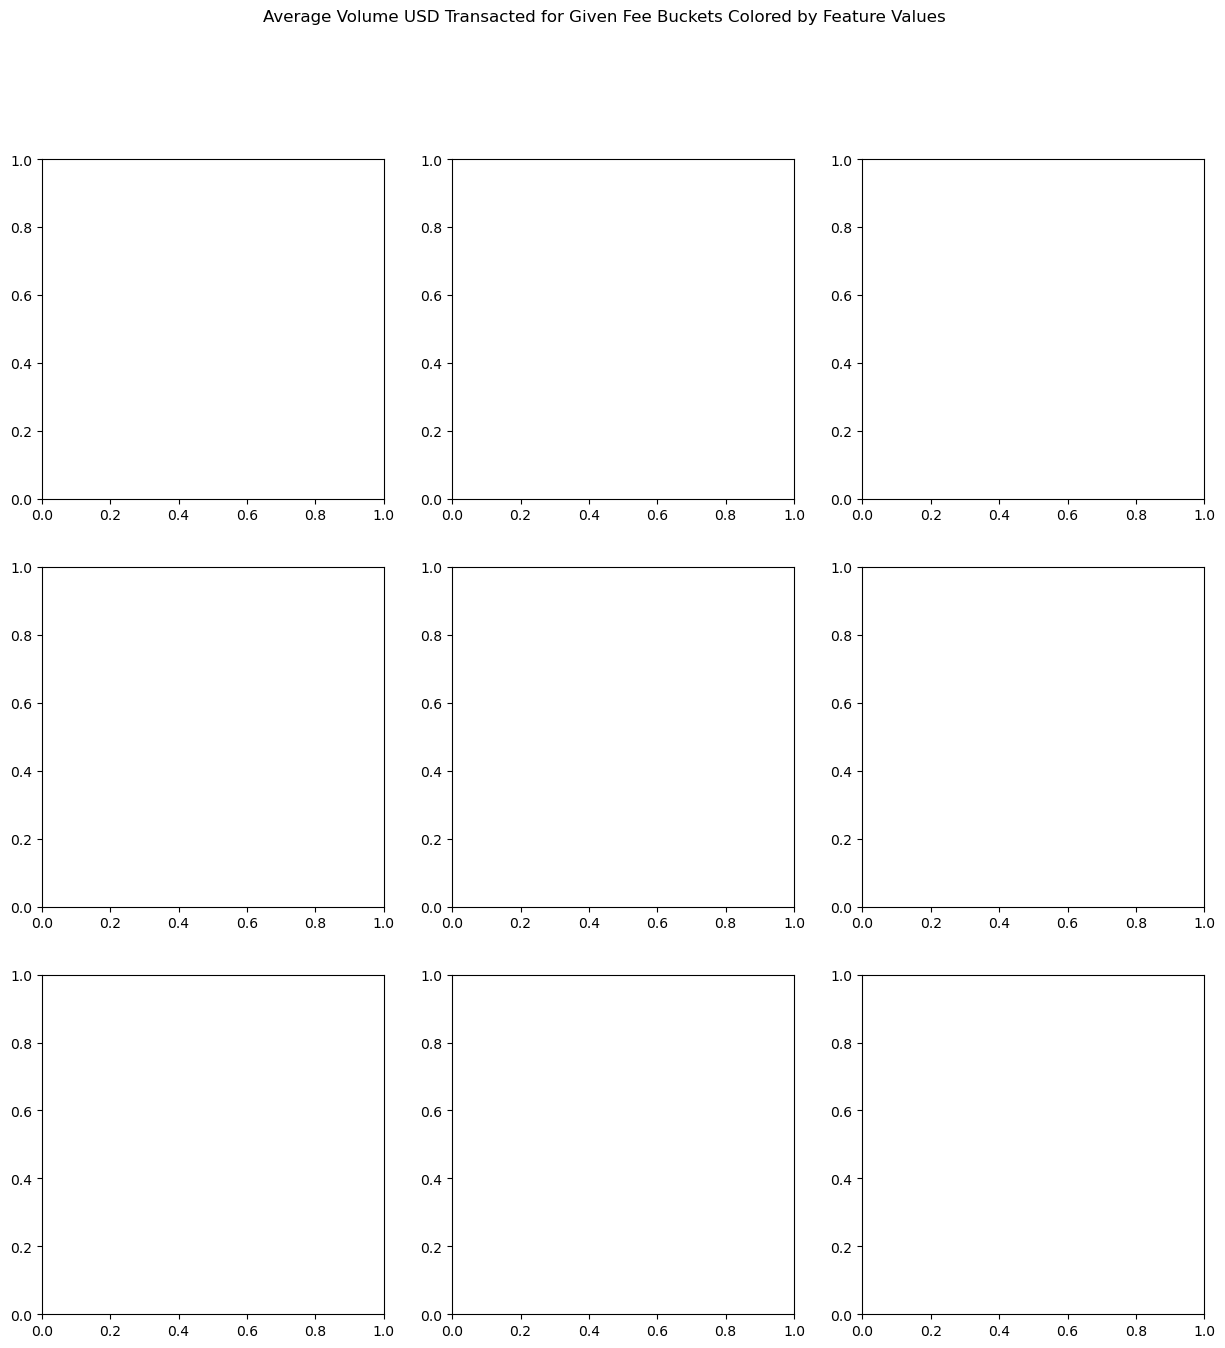

In [143]:
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

try:
    features.remove('amountUSD') 
except ValueError:
    pass  

if 'volumeUSD' not in features:
    features.append('volumeUSD')

# Prepare the grid
num_features = len(features)
cols = 3  # Adjust the number of columns as needed for your grid layout
rows = num_features // cols + (num_features % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
fig.suptitle('Average Volume USD Transacted for Given Fee Buckets Colored by Feature Values')

for i, feat in enumerate(features):
    if feat == 'volumeUSD':
        continue
    # Calculate the average 'volumeUSD' and current feature for each bucket
    agg_metrics = metrics.groupby('fee_bucket')[['volumeUSD', feat]].mean().reset_index()
    agg_metrics['fee_bucket_mid'] = agg_metrics['fee_bucket'].apply(lambda x: x.mid).astype(float)
    
    # Normalize the current feature's absolute values for coloring
    arb_pnl_norm = Normalize(vmin=agg_metrics[feat].abs().min(), vmax=agg_metrics[feat].abs().max())
    colors = coolwarm(arb_pnl_norm(agg_metrics[feat].abs()))
    
    # Determine the appropriate subplot
    ax = axs.flatten()[i]
    
    # Plot
    ax.bar(agg_metrics['fee_bucket_mid'], agg_metrics['volumeUSD'].astype('float'), alpha=0.7, color=colors, width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)
    ax.set_title(f'Colored by {feat}')
    ax.set_xlabel('Fee Bucket (Mid-point)')
    ax.set_ylabel('Average Volume USD')
    plt.colorbar(plt.cm.ScalarMappable(norm=arb_pnl_norm, cmap=coolwarm), ax=ax, label=f'Average {feat} in %')
    
    # Mark specific fee buckets
    closest_mid_point = agg_metrics['fee_bucket_mid'].sub(0.0005).abs().idxmin()
    x_value_for_line = agg_metrics.loc[closest_mid_point, 'fee_bucket_mid']
    ax.axvline(x=x_value_for_line, color='black', linestyle='--', linewidth=2, label='Constant Uniswap 0.05% Fee')
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()
